In [1]:
import os
import zipfile
from pathlib import Path

# Define paths
dataset_folder = Path("DAT-540-PROJECT/data/leapGestRecog").expanduser()  # Adjust folder name as needed
zip_path = Path("./data/archive.zip").expanduser()

if not dataset_folder.parent.exists():
    print(f"Creating the directory: {dataset_folder.parent}")
    dataset_folder.parent.mkdir(parents=True, exist_ok=True)

# Check if dataset folder exists
if not dataset_folder.exists():
    print("Dataset not found locally. Downloading...")
    
    if not zip_path.exists():
        # Run shell command to download the dataset if it doesn't exist
        !curl -L -o {zip_path} https://www.kaggle.com/api/v1/datasets/download/gti-upm/leapgestrecog
    
    # Unzip the downloaded file
    if zip_path.exists():
        print("Download complete. Extracting files...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dataset_folder)  # Extracts to the folder above the zip file
        print("Extraction complete.")
    else:
        print("Download failed. Please check your connection or Kaggle API credentials.")
else:
    print("Dataset already exists locally.")


Creating the directory: DAT-540-PROJECT\data
Dataset not found locally. Downloading...
Download complete. Extracting files...
Extraction complete.


In [ ]:
# import cv2
# import numpy as np
# import os

# # Folder containing images
# folder_path = './data/leapGestRecog/leapGestRecog/00/01_palm/'

# # List to store image data and corresponding labels (if available)
# images = []
# labels = []  # Optional if you have labels for supervised learning

# # Iterate over the image files in the folder
# for filename in os.listdir(folder_path):
#     if filename.endswith(".jpg") or filename.endswith(".png"):
#         # Read each image in grayscale
#         img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
        
#         # Ensure the image is not None
#         if img is not None:
#             # Flatten the 2D image into a 1D array (each pixel is a feature)
#             img_flattened = img.flatten()  # This converts the image to a 1D array
#             images.append(img_flattened)
            
#             # Example: if you have labels for supervised learning, you could store them
#             # labels.append(label)  # e.g., label = 0 or 1 for gesture class

# # Convert images list into a NumPy array (2D array, where each row is an image)
# X = np.array(images)
# # If labels exist, convert them to a NumPy array as well
# # y = np.array(labels)

# print("Shape of image data:", X.shape)


In [2]:
import cv2
import numpy as np
import os



# Resize images to a common size (128x128)
desired_size = (128, 128)


# initialize the list of images and labels
images = []
labels = []

# We only want to work with the first person's data for now (folder '00')
base_folder = './data/leapGestRecog/leapGestRecog/00/'

if os.path.isdir(base_folder):
    # for each gesture folder
    for gesture_folder in os.listdir(base_folder):
        gesture_path = os.path.join(base_folder, gesture_folder)
        
        # Check if it's a directory
        if os.path.isdir(gesture_path):
            
            # Use gesture folder as label
            label = gesture_folder 
            
            # for each image in the gesture folder
            for filename in os.listdir(gesture_path):
                
                # Check if the file is an image
                if filename.endswith(".jpg") or filename.endswith(".png"):
                    
                    # Read the image, convert to grayscale, resize, and normalize
                    img = cv2.imread(os.path.join(gesture_path, filename), cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                    
                        img_resized = cv2.resize(img, desired_size)
                        img_normalized = img_resized.astype('float32') / 255.0
                        images.append(img_normalized)
                        labels.append(label)

In [3]:
from sklearn.preprocessing import LabelEncoder

#Convert labels to integers (i.e. convert '01_palm' to 1)
le = LabelEncoder()
y = le.fit_transform(labels)

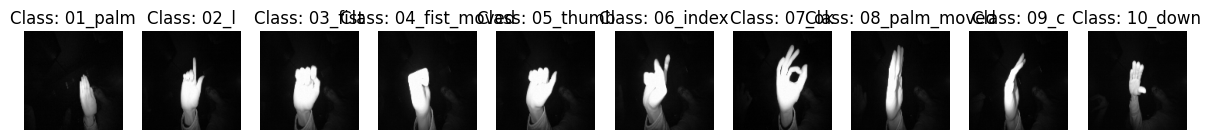

In [4]:
import matplotlib.pyplot as plt

# Display sample images from each class
classes = np.unique(y)
fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
for i, cls in enumerate(classes):
    idx = y.tolist().index(cls)
    axes[i].imshow(images[idx], cmap='gray')
    axes[i].set_title(f"Class: {le.inverse_transform([cls])[0]}")
    axes[i].axis('off')
plt.show()


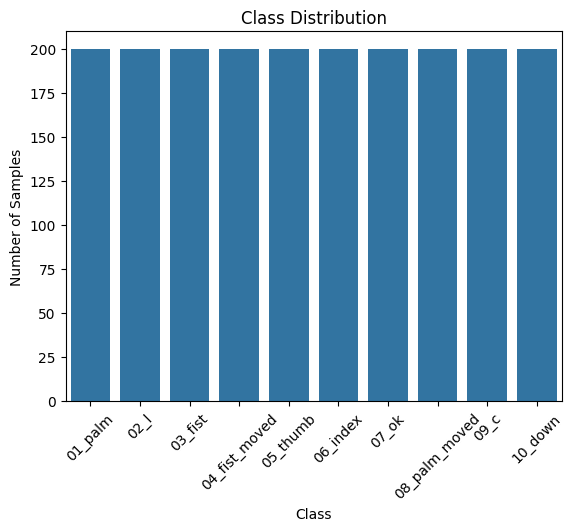

In [ ]:
import seaborn as sns

# Plot the distribution of classes, we can see that the classes are balanced
sns.countplot(x=y)
plt.xlabel('Class')
plt.xticks(ticks=classes, labels=le.inverse_transform(classes), rotation=45)
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()


In [12]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Prepare data
# X here is a 4D array (number of samples, height, width, channels)
# which we can directly use in a Conv2D layer in the next code block
X = np.array(images).reshape(-1, desired_size[0], desired_size[1], 1)  # Add channel dimension

# Convert labels to one-hot encoded vectors
y_categorical = to_categorical(y)

In [8]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Build the CNN model
# The type of CNN we will use is a Sequential model which is
# a linear stack of layers. We will add convolutional, pooling,
# and dense layers to this model.
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(desired_size[0], desired_size[1], 1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(classes), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


c:\Users\haako\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Fit the model with validation
# history here is a history object that contains the loss and accuracy values during training
# which we can use to plot the training and validation loss and accuracy

#TODO: Tune these hyper parameters
#Hyper parameters
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# See below how the loss improves and the accuracy increases (by a lot) over time
# This means that the training is working and the model is learning from the data


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.7159 - loss: 0.9841 - val_accuracy: 0.9812 - val_loss: 0.0488
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.9988 - loss: 0.0050 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 1.0000 - loss: 1.8229e-04 - val_accuracy: 1.0000 - val_loss: 7.8491e-04
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 1.0000 - loss: 4.8379e-05 - val_accuracy: 1.0000 - val_loss: 9.0991e-04
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 1.0000 - loss: 4.0142e-05 - val_accuracy: 1.0000 - val_loss: 8.0459e-04
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 1.0000 - loss: 2.4422e-05 - val_accuracy: 1.0000 - val_loss: 7.6645e-04
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 1.0000 - loss: 2.6706e-05 - val_accuracy: 1.0000 - val_loss: 7.2530e-04
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 1.000

In [17]:
# Tune these hyper parameters

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from keras_tuner import Hyperband  

def build_model(hp):
    model = Sequential()
    
    # First Convolutional Layer with tunable number of filters and kernel size
    model.add(Conv2D(
        filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(desired_size[0], desired_size[1], 1)
    ))
    model.add(MaxPooling2D((2, 2)))
    
    # Second Convolutional Layer with tunable number of filters and kernel size
    model.add(Conv2D(
        filters=hp.Int('conv_2_filters', min_value=64, max_value=256, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(MaxPooling2D((2, 2)))
    
    # Flatten and Dense Layers with tunable dense units and dropout rate
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=256, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Output Layer
    model.add(Dense(len(classes), activation='softmax'))
    
    # Compile model with tunable learning rate
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [18]:
from keras_tuner import Hyperband

# Define the tuner and its parameters
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='tuning_dir',
    project_name='hand_sign_tuning'
)

c:\Users\haako\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Run the tuner search.
# Only necessary if you want to run the search again

# tuner.search(X_train, y_train, epochs=20, validation_split=0.1, batch_size=32)

Trial 26 Complete [00h 01m 10s]

Best val_accuracy So Far: 1.0
Total elapsed time: 01h 26m 14s

Search: Running Trial #27

Value             |Best Value So Far |Hyperparameter
32                |32                |conv_1_filters
3                 |5                 |conv_1_kernel
224               |256               |conv_2_filters
5                 |3                 |conv_2_kernel
224               |128               |dense_units
0.2               |0.3               |dropout
1e-05             |1e-05             |learning_rate
20                |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
0                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.2862 - loss: 2.1837

Traceback (most recent call last):
  File "c:\Users\haako\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\haako\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\haako\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\haako\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "c:\Users\haako\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\haako\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\haako\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\haako\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\haako\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\haako\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras_tuner\src\engine\hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\haako\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "c:\Users\haako\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras_tuner\src\engine\tuner_utils.py", line 76, in on_epoch_end
    self._save_model()
  File "c:\Users\haako\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras_tuner\src\engine\tuner_utils.py", line 86, in _save_model
    self.model.save_weights(write_filepath)
  File "c:\Users\haako\AppData\Local\Programs\Python\Python311\Lib\site-packages\h5py\_hl\group.py", line 483, in __setitem__
    ds = self.create_dataset(None, data=obj)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\haako\AppData\Local\Programs\Python\Python311\Lib\site-packages\h5py\_hl\group.py", line 183, in create_dataset
    dsid = dataset.make_new_dset(group, shape, dtype, data, name, **kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\haako\AppData\Local\Programs\Python\Python311\Lib\site-packages\h5py\_hl\dataset.py", line 168, in make_new_dset
    dset_id.write(h5s.ALL, h5s.ALL, data)
  File "h5py\\_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py\\_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py\\h5d.pyx", line 281, in h5py.h5d.DatasetID.write
  File "h5py\\_proxy.pyx", line 115, in h5py._proxy.dset_rw
OSError: [Errno 28] Can't synchronously write data (file write failed: time = Tue Nov 19 10:13:56 2024
, filename = 'tuning_dir\hand_sign_tuning\trial_0026\checkpoint.weights.h5', file descriptor = 4, errno = 28, error message = 'No space left on device', buf = 000002102E603040, total write size = 168792064, bytes this sub-write = 168792064, bytes actually written = 18446744073709551615, offset = 741096)


In [ ]:
# Get the best model
# best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
# Display the best hyperparameters
# best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
# print("Best Hyperparameters:")
# print(f"Conv Layer 1 Filters: {best_hyperparameters.get('conv_1_filters')}")
# print(f"Conv Layer 1 Kernel Size: {best_hyperparameters.get('conv_1_kernel')}")
# print(f"Conv Layer 2 Filters: {best_hyperparameters.get('conv_2_filters')}")
# print(f"Conv Layer 2 Kernel Size: {best_hyperparameters.get('conv_2_kernel')}")
# print(f"Dense Units: {best_hyperparameters.get('dense_units')}")
# print(f"Dropout Rate: {best_hyperparameters.get('dropout')}")
# print(f"Learning Rate: {best_hyperparameters.get('learning_rate')}")

Best Hyperparameters:
Conv Layer 1 Filters: 32
Conv Layer 1 Kernel Size: 5
Conv Layer 2 Filters: 256
Conv Layer 2 Kernel Size: 3
Dense Units: 128
Dropout Rate: 0.30000000000000004
Learning Rate: 1e-05


In [ ]:
# # Evaluate the model on the test set
# test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
# print(f"Test Accuracy: {test_accuracy:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 1.0000 - loss: 1.1274e-04
Test Accuracy: 1.0000


In [ ]:
# X is your image data, shape: (num_samples, height, width, channels)
# y is your labels, shape: (num_samples,)

# Ensure y is in integer format (not one-hot encoded)
# If y is one-hot encoded, convert it back to integer labels
if y.ndim > 1:
    y_labels = np.argmax(y, axis=1)
else:
    y_labels = y
    
def build_model_with_parameters():
    # Best Hyperparameters
    conv_1_filters = 96
    conv_1_kernel = 3
    conv_2_filters = 96
    conv_2_kernel = 3
    dense_units = 64
    dropout_rate = 0.3
    learning_rate = 0.0001

    # Build the model
    model = Sequential()
    model.add(Conv2D(filters=conv_1_filters,
                     kernel_size=(conv_1_kernel, conv_1_kernel),
                     activation='relu',
                     input_shape=(desired_size[0], desired_size[1], 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=conv_2_filters,
                     kernel_size=(conv_2_kernel, conv_2_kernel),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(len(classes), activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

from sklearn.model_selection import StratifiedKFold

# Define the number of folds
n_splits = 5

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_no = 1
accuracy_per_fold = []
loss_per_fold = []

for train_index, val_index in skf.split(X, y_labels):
    print(f'Fold {fold_no} -------------------------------------')

    # Split data
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Ensure labels are one-hot encoded
    y_train_categorical = to_categorical(y_train, num_classes=len(classes))
    y_val_categorical = to_categorical(y_val, num_classes=len(classes))

    # Build a fresh model for each fold
    model = build_model_with_parameters()

    # Train the model
    history = model.fit(X_train, y_train_categorical,
                        epochs=20,
                        batch_size=32,
                        validation_data=(X_val, y_val_categorical),
                        verbose=1)

    # Evaluate the model
    scores = model.evaluate(X_val, y_val_categorical, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} = {scores[0]:.4f}; {model.metrics_names[1]} = {scores[1]:.4f}')
    accuracy_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    fold_no += 1


print('-------------------------------------')
print('Score per fold')
for i in range(len(accuracy_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]:.4f} - Accuracy: {accuracy_per_fold[i]:.4f}%')
print('-------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold):.4f} (+- {np.std(accuracy_per_fold):.4f})')
print(f'> Loss: {np.mean(loss_per_fold):.4f}')
print('-------------------------------------')




Fold 1 -------------------------------------
Epoch 1/20


c:\Users\haako\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 408ms/step - accuracy: 0.3454 - loss: 1.9860 - val_accuracy: 0.9850 - val_loss: 0.4776
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 468ms/step - accuracy: 0.9126 - loss: 0.4236 - val_accuracy: 0.9875 - val_loss: 0.0627
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 422ms/step - accuracy: 0.9647 - loss: 0.1245 - val_accuracy: 1.0000 - val_loss: 0.0173
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 415ms/step - accuracy: 0.9859 - loss: 0.0693 - val_accuracy: 1.0000 - val_loss: 0.0077
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 428ms/step - accuracy: 0.9877 - loss: 0.0419 - val_accuracy: 1.0000 - val_loss: 0.0044
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 473ms/step - accuracy: 0.9934 - loss: 0.0255 - val_accuracy: 1.0000 - val_loss: 0.0063
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 451ms/step - accuracy: 0.9945 - loss: 0.0258 - val_accuracy: 1.0000 - val_loss: 0.0079
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 448ms/step - accuracy: 0.9974 - loss: 0.0346 - val_accuracy: 1.000

KeyboardInterrupt: 

In [31]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


# Convert one-hot encoded y_test back to labels
y_test_classes = np.argmax(y_test, axis=1)

# Accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Test Accuracy: {accuracy:.2f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
Test Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00        36
         02_l       1.00      1.00      1.00        47
      03_fist       1.00      1.00      1.00        46
04_fist_moved       1.00      1.00      1.00        36
     05_thumb       1.00      1.00      1.00        34
     06_index       1.00      1.00      1.00        34
        07_ok       1.00      1.00      1.00        33
08_palm_moved       1.00      1.00      1.00        44
         09_c       1.00      1.00      1.00        48
      10_down       1.00      1.00      1.00        42

     accuracy                           1.00       400
    macro avg       1.00      1.00      1.00       400
 weighted avg       1.00      1.00      1.00       400



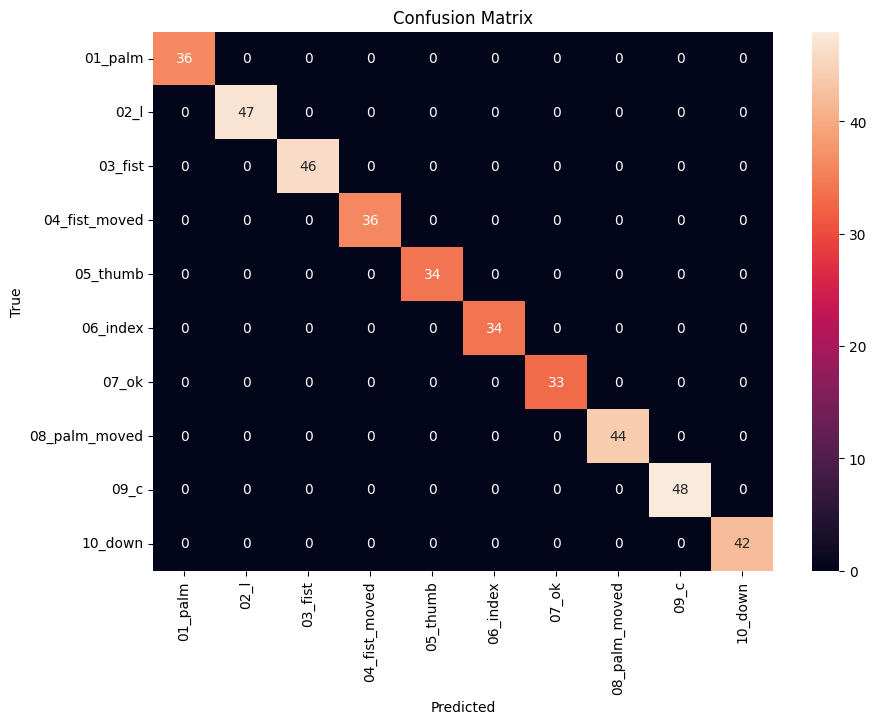

In [32]:
import seaborn as sns

cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Shows actual (y-axis) vs predicted values (x-axis)
#The diagonal represents the correct predictions
#The diagonal shows that the model never predicts false positives



In [33]:
#Save the model
model.save('gesture_recognition_model.keras')

In [ ]:
#TODO: Cross validation
# Cross validation is a technique used to evaluate the performance of a model
# on a limited data sample. It is used to estimate how the model will perform
# in a general setting. The idea is to split the data into multiple folds
# and train the model on all but one fold and test on the remaining fold.

# This can be implemented using the KFold class from scikit-learn.

In [ ]:
#TODO: Data augmentation
# Data augmentation is a technique to artificially create new training data from existing training data.
# This is done by applying random (but realistic) transformations to the existing data.
# For example, you can rotate, flip, zoom in, or change the brightness of an image.
# This can help the model generalize better to new, unseen data.
# Keras provides a built-in ImageDataGenerator class that can be used for data augmentation.


In [ ]:
import os
import cv2
# If our use case is to be able to recognize gestures in real-time, then a step we need to take is to  
# access the webcam and use the model to make predictions on the video stream.

# TODO: Acess the webcam
# To access the webcam, we can use the OpenCV library which provides
# a VideoCapture class to capture video from the webcam.

# Ensure the 'data' folder exists; if not, create it
os.makedirs('data/webcam', exist_ok=True)

cap = cv2.VideoCapture(0)

img_counter = 0

desired_size = (128, 128)

if not cap.isOpened():
    print("Cannot open camera")
    exit()
#video capture
#fourcc = cv.VideoWriter_fourcc(*'DIVX')
#out = cv.VideoWriter('output.avi', fourcc, 20.0, (128,  128))

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
 
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # write the frame video
    #out.write(gray)

    # Display the resulting frame
    cv2.imshow('frame', gray)

    if cv2.waitKey(1) == ord(' '): #space bar to capture frame
        img_resized = cv2.resize(gray, desired_size)
        img_normalized = img_resized.astype('float32') / 255.0

        img_name = f"data/webcam/image_{img_counter}.png"
        cv2.imwrite(img_name, img_normalized)

        img_counter += 1

    if cv2.waitKey(1) == ord('q'): #q to end program
        break
 
# When everything done, release the capture
cap.release()
#out.release()
cv2.destroyAllWindows()

#Access the webcam and press space bar to capture a frame as image and q to end program. little lag between keypress
#images is nomalized before saving so it can be used for prediction but cant be view directly for users

In [ ]:
#TODO: Make predictions on the video stream from the webcam
# This is something we can use in our presentation of the project
